In [1]:
import numpy as np, matplotlib.pyplot as plt, sys, os, calendar, glob, math, pickle, collections, logging, matplotlib.cm
from dateutil import parser
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

sys.path.append("../")
from inc.dataset import FlightsData

weights_dir = "../bin/models/CLASSIFICATION_1.0.0/weights/"
if not os.path.exists("../bin/data/flights_by_cell_day.pkl"): # Check data is downloaded
    raise FileNotFoundError("You must first download data by running 'cd "+ os.path.abspath("../../scripts/") +"; python download_data.py'")

with open("../bin/data/sorted_cells_latlon.pkl", "rb") as fin:
    sorted_cells_latlon = pickle.load(fin, encoding='latin1')
with open("../bin/data/flights_by_cell_day.pkl", "rb") as fin:
    flights_by_cell_day = pickle.load(fin, encoding='latin1')
with open("../bin/data/meteo_days.pkl", "rb") as fin:
    meteo_days = pickle.load(fin, encoding='latin1')
with open("../bin/data/meteo_params.pkl", "rb") as fin:
    weather_params = pickle.load(fin, encoding='latin1')
with open("../bin/data/meteo_days.pkl", "rb") as fin:
    meteo_days = pickle.load(fin, encoding='latin1')

# Dataset

The current training area is focused on the Alps as there is no time zone management for now.
This area is segmented in 1°x1°x100hPa cells, corresponding to the GFS Analysis data cells.

## Training  area

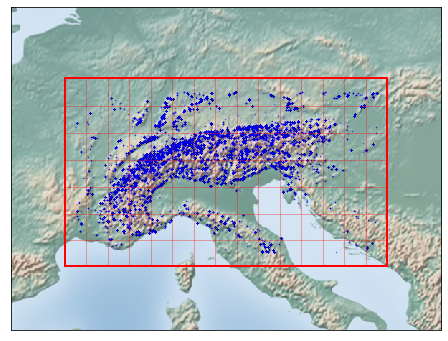

In [2]:
cell_reso = 1.0
min_lat, max_lat = min([c[0] for c in sorted_cells_latlon])-cell_reso/2., max([c[0] for c in sorted_cells_latlon])+cell_reso/2.
min_lon, max_lon = min([c[1] for c in sorted_cells_latlon])-cell_reso/2., max([c[1] for c in sorted_cells_latlon])+cell_reso/2.

plt.figure(figsize=((max_lon-min_lon)*.85, (max_lat-min_lat)*.85))
m = Basemap(projection='mill', llcrnrlon=min_lon-2.5, llcrnrlat=min_lat-2.5, urcrnrlon=max_lon+2.5, urcrnrlat=max_lat+2.5, resolution='h')
m.shadedrelief()

# Draw training weather grid (GFS 1°x1°)
for lat in range(1, round((max_lat-min_lat)/cell_reso)):
    m.plot([min_lon, max_lon], [min_lat + lat*cell_reso, min_lat + lat*cell_reso], '-', linewidth=1, color='r', alpha=0.325, latlon=True)
for lon in range(1, round((max_lon-min_lon)/cell_reso)):
    m.plot([min_lon + lon*cell_reso, min_lon + lon*cell_reso], [min_lat, max_lat], '-', linewidth=1, color='r', alpha=0.325, latlon=True)
m.plot([min_lon, max_lon, max_lon, min_lon, min_lon], [min_lat, min_lat, max_lat, max_lat, min_lat], '-', linewidth=2, color=(1., 0., 0.), latlon=True)

# Draw flights
m.scatter(np.array([f[1][4] for fd in flights_by_cell_day for f in fd]), # longitudes of training flights
          np.array([f[1][3] for fd in flights_by_cell_day for f in fd]), # latitudes of training flights
          marker='o', color='b', s=0.1, alpha=0.1, latlon=True)

plt.show()

## Flights

We consider only the take-off coordinates (latitude, longitude, altitude) of a flight because, far from any take-off area, an absence of flight does not implies non-flyability.

Number of days with weather data and flights for these days.

dow [111383, 107993, 117721, 131987, 154665, 266616, 238255]


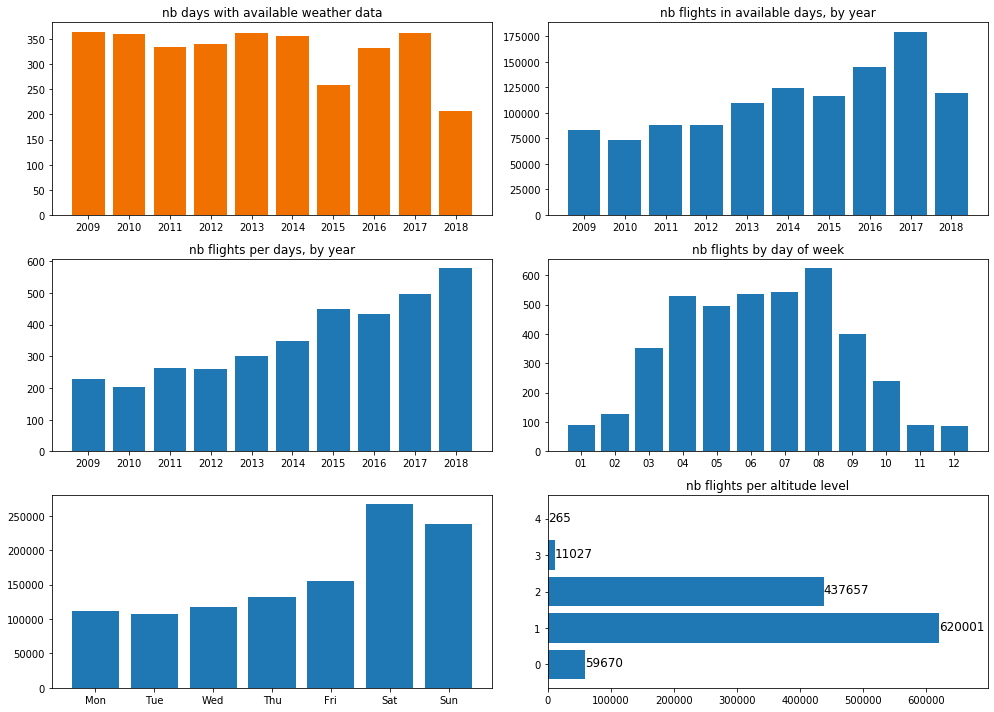

In [3]:
# Count days per year
counter_days, counter_months = collections.Counter(), collections.Counter()
for day in meteo_days:
    counter_days[str(day.year)] += 1
    counter_months["%02d"%day.month] += 1

# Count flights per year
counter_flights_by_year, counter_flights_by_month, counter_flights_by_alt, counter_flights_by_dow = collections.Counter(), collections.Counter(), collections.Counter(), collections.Counter()
for cell_day in flights_by_cell_day:
    for flight in cell_day:
        counter_flights_by_alt[FlightsData.kAltitude(flight[1][5])] += 1
    try:
        counter_flights_by_year [cell_day[0][0][0:4]] += len(cell_day) # counter[year]  += nb_flights
        counter_flights_by_month[cell_day[0][0][5:7]] += len(cell_day) # counter[month] += nb_flights
        counter_flights_by_dow  [parser.parse(cell_day[0][0]).strftime("%a")] += len(cell_day) # counter[dow]   += nb_flights
    except IndexError:
        pass
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))
years, months, dow = sorted(list(counter_days)), sorted(list(counter_months)), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,0].set_title("nb days with available weather data")
axes[0,0].bar(years, [counter_days[y] for y in years], color='#f07000')
axes[0,1].set_title("nb flights in available days, by year")
axes[0,1].bar(years, [counter_flights_by_year[y] for y in years])
axes[1,0].set_title("nb flights per days, by year")
axes[1,0].bar(years, [counter_flights_by_year[y]/counter_days[y] for y in years])
axes[1,1].set_title("nb flights per days, by month")
axes[1,1].bar(months, [counter_flights_by_month[m]/counter_months[m] for m in months])
axes[1,1].set_title("nb flights by day of week")
axes[2,0].bar(dow, [counter_flights_by_dow[d] for d in dow])
print("dow", [counter_flights_by_dow[d] for d in dow])

# Flights by altitude
axes[2,1].set_title("nb flights per altitude level")
nb_alts = max(counter_flights_by_alt.keys())+1
axes[2,1].barh(["%d"%alt for alt in range(nb_alts)], [counter_flights_by_alt[alt] for alt in range(nb_alts)])
for alt in range(nb_alts):
    axes[2,1].text(counter_flights_by_alt[alt], alt-0.06, str(counter_flights_by_alt[alt]), fontsize=12)   
axes[2,1].set_xlim(0, 1.125*max(counter_flights_by_alt.values()))

fig.tight_layout()

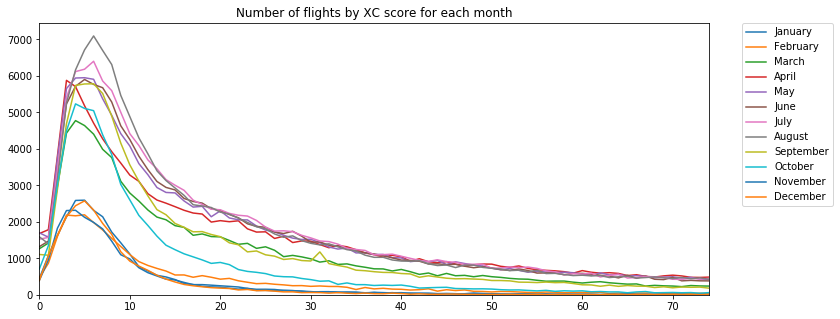

In [4]:
max_score = 75
pts = [[] for m in range(0, 12)]

for cell_day in flights_by_cell_day:
    try:
        pts[int(cell_day[0][0][5:7])-1] += [f[1][0] for f in cell_day]
    except IndexError:
        pass

plt.figure(figsize=(12, 5))
plt.title("Number of flights by XC score for each month")
for m in range(12):
    plt.plot(np.histogram(pts[m], bins=max_score, range=(0, max_score))[0], label=calendar.month_name[m+1])
plt.xlim(0., max_score-1)
plt.ylim(ymin=0.)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

## Weather parameters

The weather paramaters present in the GFS Analysis data has varied with time. We must select a subset present during the whole training interval.

In [5]:
nbh = 3
nbp = len(weather_params)//nbh # Number of parameters per hour
for krow in range(nbp):
    print("{: <39} {: <39} {: <39}".format(*[("%02d:00 %s at %s hPa" % (weather_params[krow+h*nbp][0],
                                                                        weather_params[krow+h*nbp][1],
                                                                    str(weather_params[krow+h*nbp][2][0][1]))).replace(" at 0 hPa", "") for h in range(nbh)]))

06:00 Precipitable water                12:00 Precipitable water                18:00 Precipitable water               
06:00 Cloud water                       12:00 Cloud water                       18:00 Cloud water                      
06:00 Vertical velocity at 1000 hPa     12:00 Vertical velocity at 1000 hPa     18:00 Vertical velocity at 1000 hPa    
06:00 Vertical velocity at 900 hPa      12:00 Vertical velocity at 900 hPa      18:00 Vertical velocity at 900 hPa     
06:00 Vertical velocity at 800 hPa      12:00 Vertical velocity at 800 hPa      18:00 Vertical velocity at 800 hPa     
06:00 Vertical velocity at 700 hPa      12:00 Vertical velocity at 700 hPa      18:00 Vertical velocity at 700 hPa     
06:00 Vertical velocity at 600 hPa      12:00 Vertical velocity at 600 hPa      18:00 Vertical velocity at 600 hPa     
06:00 Vertical velocity at 500 hPa      12:00 Vertical velocity at 500 hPa      18:00 Vertical velocity at 500 hPa     
06:00 Vertical velocity at 400 hPa      

# Neural Network

## Introduction

The problem of flyability prediction is formulated as a classification problem where the input X is the weather data  in a 3D cell and the output Y is the absence/presence of at least one reported flight in this cell.
We assume that the presence of reported flight implies _flyability_ but, absence of reported flight does not imply _flyability_.
The gap between reported flights and _flyability_ is explained by what we call the [population](#Population-Block).

<p align="center"><img src="imgs/prediction_training_population.svg" width="70%"/></p>

## Network Architecture

Defined in [model.py](../inc/model.py)

There are two different models:
* The **_cells_** model: takes the weather data for a cell, and gives prediction for the whole cell
* The **_spots_** model: takes the weather data for a cell and gives different predictions for each take-off spot of the cell, taking into account their learned specificities regarding the wind

The networks are a combination of handcrafted models with internal variables (Wind Block, Population Block) and neural networks (Flyability Block, Crossability Block), all optimized together.

### Legend

The tensors going through the network are drawn as follows. The first and last tensor dimensions are not drawn. The first one is `nb_samples` (number of training days) and the last one is the `feature_dimension`, which is given between parenthesis beside the variable name.
The optimized variables are drawn the same way, but, of course, they do not have a first `nb_samples` dimension.

<p align="center"><img src="imgs/nn_legend.svg" width="60%"/></p>

For example, the "wind (8)" tensor is of shape `(nb_samples, nb_cells, nb_altitudes=5, nb_hours=3, feature_dimension=8)`.

| <h3>Cells</h3> | <h3>Spots</h3> |
| :-: | :-: |
| <img src="imgs/nn_cells.svg" width="100%"/> | <img src="imgs/nn_spots.svg" width="100%"/> |


## Population Block

The decision for a paraglider to go fly is modeled by a random variable of Bernoulli distribution of parameter named the _flyability_.
The paragliders decisions are supposed independent.

$\mathbb{P}(X=x) = \left\{\begin{array}{ll} flyability &\quad\mbox {if }x=\text{go fly}, \\ 1-flyability &\quad\mbox {if }x=\text{do not fly} \end{array} \right.$

The Population Block computes the probability that at least one person goes fly given the _flyability_ and the _population_.
The _population_ for each cell and spot is an inner variable optimized during training.

$\text{Probability that at least 1 person goes fly} = \left\{\begin{array}{ll}flyability \cdot population   & \text{if} ~~ population \le 1\\
																	1-(1-flyability)^{population} & \text{if} ~~ population > 1\end{array}\right.$

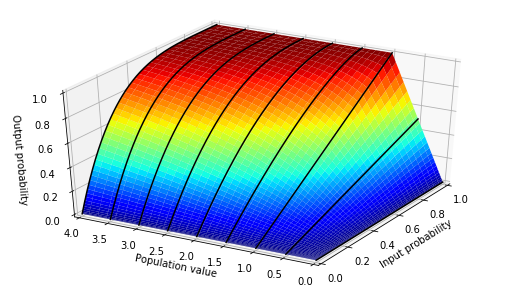

In [6]:
r = 200
in_proba   = np.array([[1.*(float(x)/float(r-1))**2. for y in range(r)] for x in range(r)], np.float)
population = np.array([[4.*(float(y)/float(r-1))**2. for y in range(r)] for x in range(r)], np.float)
out_proba  = np.array([[in_proba[x,y]*population[x,y] if population[x,y]<=1. else 1. - (1. - in_proba[x,y])**population[x,y] for y in range(r)] for x in range(r)], np.float)

logging.getLogger().disabled = True
ax = plt.figure(figsize=(9,5)).add_subplot(111, projection='3d')
ax.view_init(35, 210)
ax.set_xlim3d(0., np.amax(in_proba))
ax.set_ylim3d(0., np.amax(population))
ax.set_xlabel('Input probability')
ax.set_ylabel('Population value')
ax.set_zlabel('Output probability')

ax.plot_surface(in_proba, population, out_proba, cmap=matplotlib.cm.jet)

for p in [0.5*p for p in range(0,2)]:
    ax.plot([1.*(float(x)/float(r-1))**2. for x in range(r)], [p for x in range(r)], [p*(float(x)/float(r-1))**2. for x in range(r)], alpha=1, color='black', linewidth=1.5, zorder=10)
for p in [0.5*p for p in range(2,9)]:
    ax.plot([1.*(float(x)/float(r-1))**2. for x in range(r)], [p for x in range(r)], [1. - (1. - 1.*(float(x)/float(r-1))**2.)**p for x in range(r)], alpha=1, color='black', linewidth=1.5, zorder=10)

logging.getLogger().disabled = False

### Date & day of week modifiers

The Population Block takes into account the date (0 to 1 from the start to the end of the training interval) and the one-hot encoded day of week from Monday to Sunday.

$population(date, dow) = \mathbf{cell\_or\_spot\_population} \cdot \mathbf{dow\_factor(}dow\mathbf{)} \cdot (1+\mathbf{date\_factor} \cdot date)$

In [7]:
date_factor = np.load(weights_dir+"population_date.npy")[0]

print("date_factor =", date_factor[0], "i.e. +%.1f%% in %.1f years, supposed linear."%(date_factor[0]*100., (meteo_days[-1]-meteo_days[0]).days/365.))

if False:
    dow_factor  = np.load(weights_dir+"population_dow.npy")[0]
    plt.figure(figsize=(8, 3.5))
    plt.bar(calendar.day_name, dow_factor)
    plt.title('dow_factor')
    plt.show()

date_factor = 1.3891177 i.e. +138.9% in 9.6 years, supposed linear.


### Cells

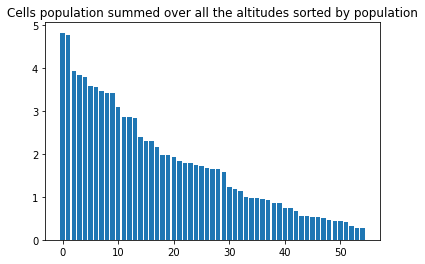

In [8]:
cell_population = [np.sum(np.load(f)) for f in sorted(glob.glob(weights_dir+"population_alt_cell_*.npy"))]

plt.bar(range(len(cell_population)), sorted(cell_population)[::-1])
plt.title("Cells population summed over all the altitudes sorted by population")
plt.show()

### Spots

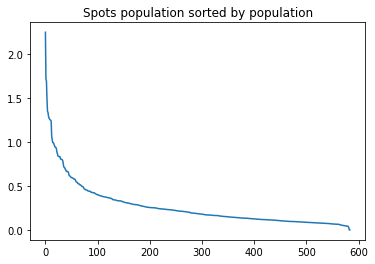

In [9]:
spot_population = np.concatenate([np.load(f)[0] for f in sorted(glob.glob(weights_dir+"population_0_spots__cell_*.npy"))])

plt.plot(np.sort(spot_population)[::-1])
plt.title("Spots population sorted by population")
plt.show()

## Wind Block

### Input

<img src="imgs/wind_parameterization.svg" width="20%" align="right">

The wind_vector from GFS is quantized in 8 directions (0°, 45°, 90°, 135°, 180°, -135°, -90°, -45°)


$\text{For } d \text{ in }  \left\{0, \dots ,7\right\},$

$wind\left[d\right] = \left\{\begin{array}{cl}
\left\lVert\overrightarrow{wind\_vector}\right\rVert & \text{if} ~ d = quantized\_diretion(\overrightarrow{wind\_vector})\\
0 & \text{otherwise}
\end{array}\right.$

### Model
#### Cells

For the cells forecasts, only the norm is considered:

$predicted\_wind = sum(wind) \cdot (1 + \mathbf{mountainess\_factor} \cdot mountainess)$

In [10]:
mountainess_factor = np.load(weights_dir+"wind_block_cells_0.npy")[0]
print("mountainess_factor =", mountainess_factor)

mountainess_factor = 0.5023645


#### Spots
The returned value is the dot product between the wind and the direction_factor at all altitudes, interpolated at relevant_altitude.


$predicted\_wind\left[alt\right] = sum\left(\overrightarrow{wind\_vector}\left[alt\right] \cdot \overrightarrow{\mathbf{direction\_factor}} \right)$

$predicted\_wind\_spot = predicted\_wind\left[\mathbf{relevant\_altitude}\right]$

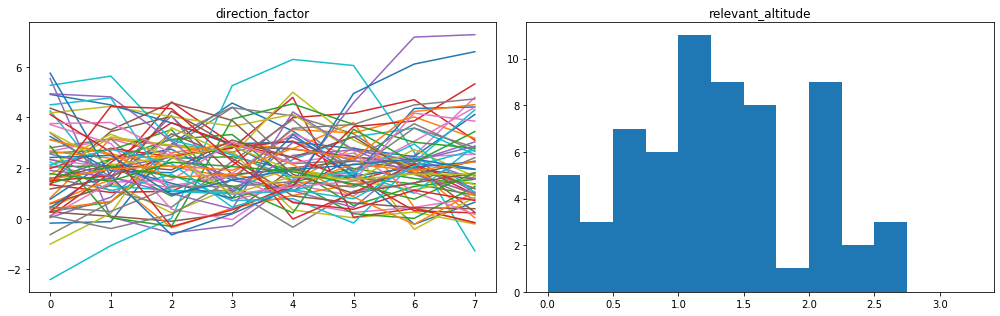

In [11]:
direction_factor  = [np.load(f)[0] for f in glob.glob(weights_dir+"wind_block_spots_0__cell_*.npy")]
relevant_altitude = [np.load(f)[0,0] for f in glob.glob(weights_dir+"wind_block_spots_1__cell_*.npy")]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4.5))
for spot in direction_factor:
    axes[0].plot(spot)
axes[0].set_title("direction_factor")
axes[1].hist(relevant_altitude, bins=[v/4.0 for v in range(0,14)])
axes[1].set_title("relevant_altitude")
fig.tight_layout()